In [1]:
import os
import pandas as pd
import numpy as np
import sys
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from training_nn import training_rnn
from evaluation import evaluate_model_rnn, plot_loss


In [4]:
from process_data import get_desc

In [5]:
SEED = 42
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [6]:
train = pd.read_csv('/kaggle/input/ml-mutational-learning/train.csv')
test = pd.read_csv('/kaggle/input/ml-mutational-learning/test.csv')

In [7]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)


In [8]:
def code_ab(x):
    type_ab = {'LY16': 0, 'REGN33': 1, 'REGN87': 2, 'LY555': 3}
    return type_ab[x['Antibody']]

In [9]:
train['type_ab'] = train.apply(code_ab, axis=1)
test['type_ab'] = test.apply(code_ab, axis=1)

In [141]:
train

junction_aa    v_call  consensus_count    j_call  \
0       KNEGFNCYIPLVTYGFHTTTGVSY  IGHV_RBD                1  IGHJ_RBD   
1       KNKGFNCYSPITEYGFFPTNGKNF  IGHV_RBD                2  IGHJ_RBD   
2       SKQGFNCYCPLIGYGFQRTFGVGW  IGHV_RBD                1  IGHJ_RBD   
3       KNRQFNCYWPLVRYGFWTTSGVGW  IGHV_RBD                1  IGHJ_RBD   
4       KNPGFNCYLPLGHYGFQPTNGRDF  IGHV_RBD                3  IGHJ_RBD   
...                          ...       ...              ...       ...   
192268  KNEGFNCYYPIVSYGFQRTVGNGF  IGHV_RBD                1  IGHJ_RBD   
192269  KNEGFNCYMPLNSYGFYPTTGMGY  IGHV_RBD                7  IGHJ_RBD   
192270  HLEGFNCYWPLVSYGFYRTSGQGY  IGHV_RBD                9  IGHJ_RBD   
192271  QNEGFNCYSPILSYGFHPTNGISW  IGHV_RBD                1  IGHJ_RBD   
192272  KNKGFNCYQPIIPYGFYRTSGDSY  IGHV_RBD                1  IGHJ_RBD   

        clonal_frequency  Label  Distance Antibody  \
0               0.000028      0         7     LY16   
1               0.000093      1         9     LY16   
2               0.000028      0         9     LY16   
3               0.000028      0         9     LY16   
4               0.000140      1         7     LY16   
...                  ...    ...       ...      ...   
192268          0.000012      0         7    LY555   
192269          0.000462      1         5    LY555   
192270          0.000594      1         8    LY555   
192271          0.000066      1         8    LY555   
192272          0.000012      0        10    LY555   

                                                     repr  type_ab  
0       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        0  
1       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        0  
2       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        0  
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        0  
4       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        0  
...                                                   ...      ...  
192268  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        3  
192269  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        3  
192270  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...        3  
192271  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        3  
192272  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        3  

[192273 rows x 10 columns]

junction_aa    v_call  consensus_count    j_call  \
26880   GNTGFNCYCPIKNYGFQRTGGLGW  IGHV_RBD                1  IGHJ_RBD   
26881   KNTGFNCYLPLVRYGFQTTAGGDW  IGHV_RBD                1  IGHJ_RBD   
26882   KNTGFNCYRPLNTYGFWRTSGINY  IGHV_RBD                1  IGHJ_RBD   
26883   KNKGFNCYDPITRYGFWPTNGSNW  IGHV_RBD                1  IGHJ_RBD   
26884   KNRGFNCYGPLVAYGFQRTCGMGW  IGHV_RBD                1  IGHJ_RBD   
...                          ...       ...              ...       ...   
147092  KNRKFNCYAPLRPYGFFRTSGMNW  IGHV_RBD                1  IGHJ_RBD   
147093  KNRGFNCYFPLLPYGFHTTFGIGW  IGHV_RBD                1  IGHJ_RBD   
147094  KNQGFNCYPPIMAYGFFTTSGRDW  IGHV_RBD                1  IGHJ_RBD   
147095  VVKKFNCYDPLVHYGFQRTTGLGY  IGHV_RBD                4  IGHJ_RBD   
147096  KNQGFNCYAPLRHYGFWRTGGRGY  IGHV_RBD                2  IGHJ_RBD   

        clonal_frequency  Label  Distance Antibody  \
26880           0.000008      0        10   REGN33   
26881           0.000008      0         9   REGN33   
26882           0.000007      1         9   REGN33   
26883           0.000008      0         9   REGN33   
26884           0.000008      0         8   REGN33   
...                  ...    ...       ...      ...   
147092          0.000007      1        11   REGN33   
147093          0.000008      0         8   REGN33   
147094          0.000007      1        11   REGN33   
147095          0.000031      0        10   REGN33   
147096          0.000015      1         8   REGN33   

                                                     repr  type_ab  
26880   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...        1  
26881   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
26882   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
26883   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
26884   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
...                                                   ...      ...  
147092  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
147093  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
147094  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
147095  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
147096  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  

[120217 rows x 10 columns]

In [11]:
def get_data(train, test, samples = 200, target_ab = 'REGN33'):
    target_df = train.loc[train['Antibody'] == target_ab]
    rest_df = train.loc[train['Antibody'] != target_ab]
    target_test = test.loc[test['Antibody'] == target_ab]
    sample_target = target_df.sample(n=samples, random_state=SEED)
    train_target = sample_target.iloc[:100, :]
    valid_target = sample_target.iloc[100:, :]
    return train_target, valid_target, target_test, rest_df

In [12]:
train_target, valid_target, target_test, rest_df = get_data(train, test)

In [13]:
class Data(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def transform_dtype(self, item):
        return torch.tensor(item, dtype=torch.float32)
        
    
    def __getitem__(self, idx):
        feature = self.transform_dtype(self.df.repr.iloc[idx])
        label = self.transform_dtype(self.df.Label.iloc[idx])
        ab = self.df.type_ab.iloc[idx]
        return feature, ab, label

In [14]:
def prepare_dataloader(df, batch_size=10, shuffle=True):
    dataset = Data(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [15]:
trainloader_rest = prepare_dataloader(rest_df, shuffle=True, batch_size=10)
validloader = prepare_dataloader(valid_target, shuffle=False, batch_size=2)
trainloader_target = prepare_dataloader(train_target, shuffle=True, batch_size=1)
testloader = prepare_dataloader(target_test, shuffle=False, batch_size=50)

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_lentgth, hidden_size, num_layers=10, num_classes=1):
        super(RNN, self).__init__()
        self.embed = nn.Embedding(4, 24, dtype=torch.float32)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.linear1 = nn.Linear(seq_lentgth*hidden_size, 100)
        self.linear2 = nn.Linear(100, num_classes)

    def forward(self, x, ab_idx):
        embed = self.embed(ab_idx)
        embed = torch.unsqueeze(embed, 2)
        embed = torch.cat((embed, x), dim=2)
        x, h_1 = self.rnn(embed)
        x = x.reshape(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [21]:
model = RNN(41, 24, 140).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

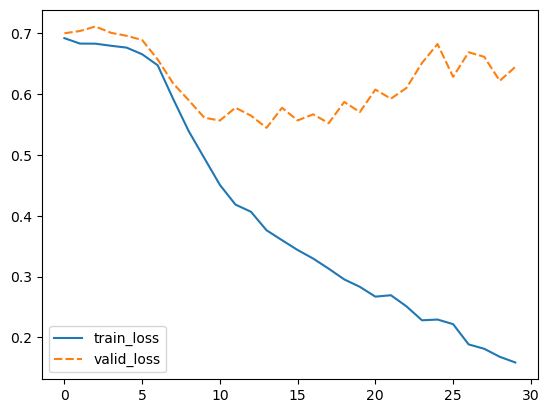

In [116]:
plot_loss(loss_train_hist, loss_valid_hist)

In [117]:
evaluate_model(testloader, model)

accuracy    recall  precision  f1_scor       auc
0  0.756083  0.695548   0.790864  0.74015  0.838347

In [17]:
model = RNN(41, 24, 140).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 20  # было 10 эпох
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_rest, validloader)

100%|██████████| 20/20 [35:33<00:00, 106.66s/it]


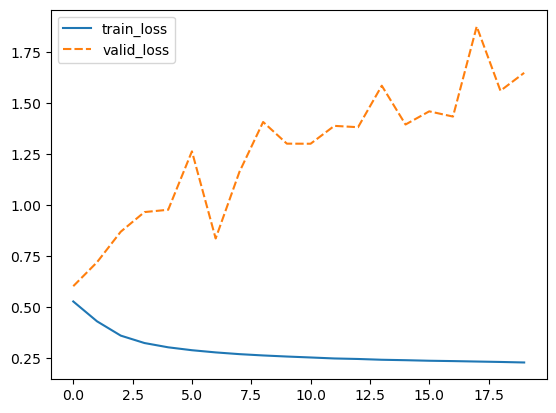

In [18]:
plot_loss(loss_train_hist, loss_valid_hist)

In [19]:
evaluate_model_rnn(testloader, model)   # copy model на этом мементе

accuracy    recall  precision   f1_scor       auc
0  0.517706  0.041973   0.845921  0.079977  0.743457

#### Страдает recall, модель осторожничает

In [112]:
def copy_model(model, *args):
    model_copy = type(model)(*args)
    model_copy.load_state_dict(model.state_dict())
    return model_copy.to(device)
    

In [125]:
model_copy = copy_model(model, 41, 24, 140)

In [119]:
def freeze_weights(model, name_layers=['linear1', 'linear2']):
    for name, param in model.named_parameters():
        if not any([layer in name for layer in name_layers]):
            param.requires_grad = False
    return model
    
    

In [ ]:
model_copy = freeze_weights(model_copy)

In [105]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-3)  # можно менять learning rate -> 1e-3 лучше себя показал
num_epochs = 10
loss_train_hist, loss_valid_hist = training_rnn(model_copy, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [107]:
evaluate_model_rnn(testloader, model_copy)

accuracy    recall  precision  f1_scor       auc
0  0.819495  0.890721   0.779381  0.83134  0.903893

In [135]:
model_copy_2 = copy_model(model, 41, 24, 140)

In [136]:
model_copy_2 = freeze_weights(model_copy_2, name_layers=['linear2'])

In [137]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_copy_2.parameters(), lr=1e-3)  # можно менять learning rate -> 1e-3 лучше себя показал
num_epochs = 10
loss_train_hist, loss_valid_hist = training_rnn(model_copy_2, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [176]:
evaluate_model_rnn(testloader, model_copy_2)  # разморозка последнего слоя сработала хуже

#### Нагенерируем выборки предсказаний для разных сэмплов n = 40.

In [168]:
target_test.head()

junction_aa    v_call  consensus_count    j_call  \
2986  KNAGFNCYTPLKQYGFWRTGGRNW  IGHV_RBD                1  IGHJ_RBD   
2987  KNKGFNCYSPLYAYGFWRTQGEGF  IGHV_RBD                1  IGHJ_RBD   
2988  KNRGFNCYSPLRRYGFWTTAGMGW  IGHV_RBD                1  IGHJ_RBD   
2989  TGTGFNCYNPLCTYGFQRTVGRNW  IGHV_RBD                1  IGHJ_RBD   
2990  KNKGFNCYAPLSPYGFWPTAGRGW  IGHV_RBD                2  IGHJ_RBD   

      clonal_frequency  Label  Distance Antibody  \
2986          0.000007      1        10   REGN33   
2987          0.000008      0         9   REGN33   
2988          0.000008      0         9   REGN33   
2989          0.000008      0        11   REGN33   
2990          0.000015      1         8   REGN33   

                                                   repr  type_ab  
2986  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
2987  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
2988  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
2989  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1  
2990  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1

In [162]:
target_df = train.loc[train['Antibody'] == 'REGN33']

In [169]:
seeds = np.arange(40)

In [182]:
target_data = []
for seed in seeds:
    sample_target = target_df.sample(n=200, random_state=seed)
    train_target = sample_target.iloc[:100, :]
    trainloader = prepare_dataloader(train_target, shuffle=True, batch_size=1)
    target_data.append(trainloader)


In [189]:
auc_scratch = []
for i in range(len(target_data)):
    scratch_model = RNN(41, 24, 140).to(device)
    optimizer = torch.optim.Adam(scratch_model.parameters(), lr=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    num_epochs = 30
    _, _ = training_rnn(scratch_model, criterion, optimizer, num_epochs, target_data[i])
    metrics = evaluate_model_rnn(testloader, scratch_model)
    auc_scratch.append(metrics.auc.values[0])
    

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


In [190]:
len(auc_scratch)

40

In [199]:
auc_transfer_learn = []
for i in range(len(target_data)):
    model_copy_ = copy_model(model, 41, 24, 140)
    model_copy_ = freeze_weights(model_copy_)
    optimizer = torch.optim.Adam(model_copy_.parameters(), lr=1e-3)
    num_epochs = 10
    _, _ = training_rnn(model_copy_, criterion, optimizer, num_epochs, target_data[i])
    metrics = evaluate_model_rnn(testloader, model_copy_)
    auc_transfer_learn.append(metrics.auc.values[0])


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


In [193]:
import pickle

In [194]:
def save_obj(obj, name: str):
    with open(name, 'wb') as config_file:
        pickle.dump(obj, config_file)

In [195]:
save_obj(auc_scratch, 'auc_scratch')

In [201]:
save_obj(auc_transfer_learn, 'auc_transfer_learn')


In [202]:
auc_scratch = np.array(auc_scratch)
auc_transfer_learn = np.array(auc_transfer_learn)

In [204]:
np.mean(auc_scratch)

0.8160637650102665

In [214]:
np.std(auc_scratch)

0.027534170345297256

In [205]:
np.mean(auc_transfer_learn)

0.8853405118784664

In [215]:
np.std(auc_transfer_learn)

0.012977391668459497

In [206]:
import seaborn as sns

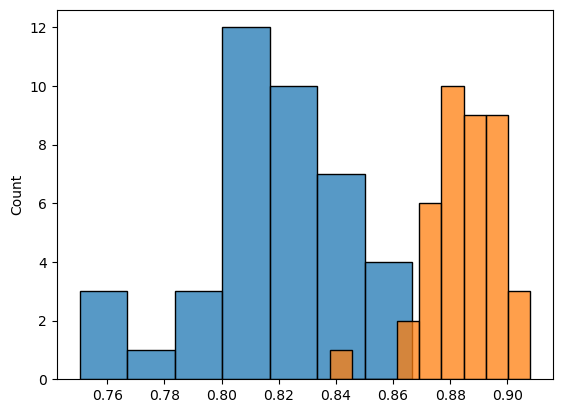

In [213]:
sns.histplot(data=auc_scratch);
sns.histplot(data=auc_transfer_learn);

In [216]:
from scipy import stats

42

In [218]:
_, pvalue = stats.ttest_ind(auc_transfer_learn, auc_scratch, equal_var=False, random_state=SEED, alternative='greater')

In [219]:
pvalue

1.9054836587266133e-20